# Predicting customer lifetime value using machine learning
- Customer Lifetime value is measured as the next 6 month total orders value (revenue)
- Our goal is to predict the lifetime value for each customer.

Assumptions:
- 30 days in a month (6 months = 180 days)

## Load Raw Data Sets and Parameters

In [33]:
%reload_kedro
from process.pipelines.data_processing import nodes as dp
from process.pipelines.data_science import nodes as ds
# Run help(dp) or help(ds) for documentation on functions
customers = catalog.load('customers').set_index('customer_id')
transactions = catalog.load('transactions')
parameters = catalog.load('parameters')

2021-12-04 20:25:23,192 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-12-04 20:25:23,217 - root - INFO - ** Kedro project LTV Model
2021-12-04 20:25:23,218 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-12-04 20:25:23,227 - root - INFO - Registered line magic `run_viz`
2021-12-04 20:25:23,230 - kedro.io.data_catalog - INFO - Loading data from `customers` (CSVDataSet)...
2021-12-04 20:25:23,316 - kedro.io.data_catalog - INFO - Loading data from `transactions` (CSVDataSet)...
2021-12-04 20:25:23,542 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


## Exporatory Analysis

In [2]:
customers.head()

,state,age,gender,income,is_married,promo_group_1,promo_group_2,customer_loyalty_index,brand_awareness_index
customer_id,,,,,,,,,
0,NJ,64,Female,65000.0,Y,A,X,0.058849,1.969644e-01
1,NY,26,Female,43000.0,Y,A,Z,-4.872865,2.970386e-14
2,NH,55,Female,93000.0,Y,C,X,NaN,NaN
3,ME,18,Female,68000.0,N,B,Z,0.152339,2.341961e-03
4,CA,41,Female,25000.0,N,A,Y,0.732875,8.073341e-14


Female    0.49809
Male      0.29921
Other     0.20270
Name: gender, dtype: float64


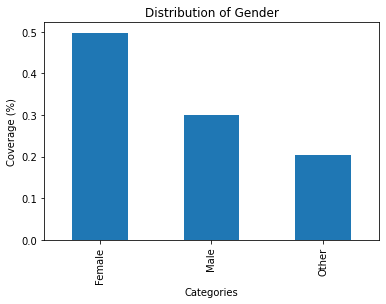

In [3]:
ax = customers.gender.value_counts(normalize = True).plot.bar()
ax.set_title("Distribution of Gender")
ax.set_xlabel("Categories")
ax.set_ylabel("Coverage (%)")
print(customers.gender.value_counts(normalize = True))

N    0.56061
Y    0.43939
Name: is_married, dtype: float64


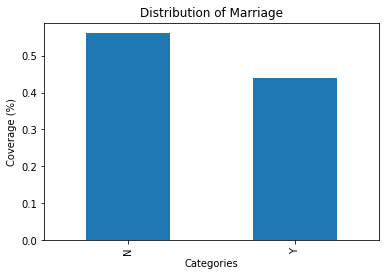

In [4]:
ax = customers.is_married.value_counts(normalize = True).plot.bar()
ax.set_title("Distribution of Marriage")
ax.set_xlabel("Categories")
ax.set_ylabel("Coverage (%)")
print(customers.is_married.value_counts(normalize = True))

TX    0.113060
CA    0.112743
NJ    0.111744
NY    0.111427
GA    0.110934
NH    0.110534
FL    0.109935
ME    0.109911
MA    0.109712
Name: state, dtype: float64


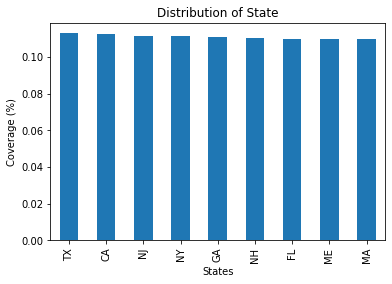

In [6]:
ax = customers.state.value_counts(normalize = True).plot.bar()
ax.set_title("Distribution of State")
ax.set_xlabel("States")
ax.set_ylabel("Coverage (%)")
print(customers.state.value_counts(normalize = True))

Text(0, 0.5, 'Count')

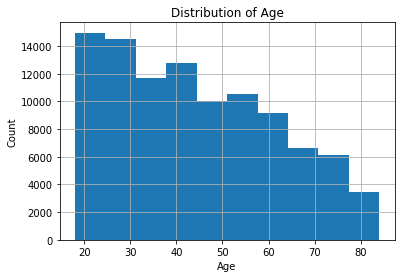

In [7]:
ax = customers.age.hist()
ax.set_title("Distribution of Age")
ax.set_xlabel("Age")
ax.set_ylabel("Count")

Text(0, 0.5, 'Years')

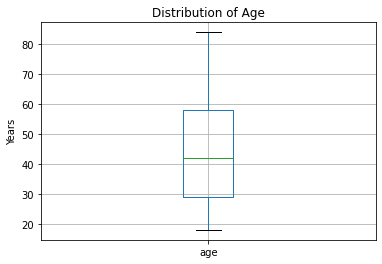

In [8]:
ax = customers.boxplot(column='age')
ax.set_title("Distribution of Age")
ax.set_ylabel("Years")                    

Text(0, 0.5, 'Count')

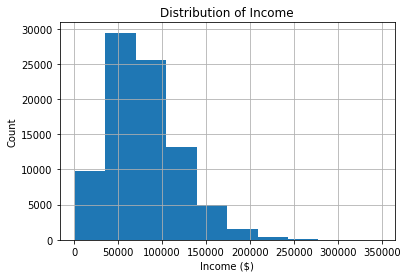

In [9]:
ax = customers.income.hist()
ax.set_title("Distribution of Income")
ax.set_xlabel("Income ($)")
ax.set_ylabel("Count")

Text(0, 0.5, 'Income ($)')

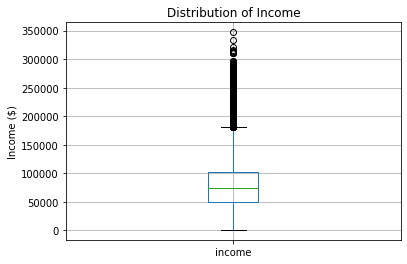

In [10]:
ax = customers.boxplot(column='income')
ax.set_title("Distribution of Income")
ax.set_ylabel("Income ($)")      

Text(0, 0.5, 'Count')

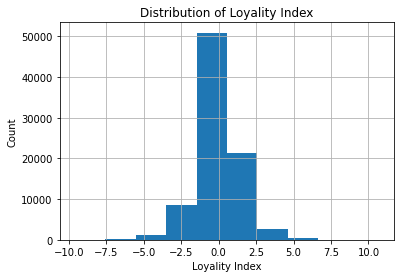

In [11]:
ax = customers.customer_loyalty_index.hist()
ax.set_title("Distribution of Loyality Index")
ax.set_xlabel("Loyality Index")
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

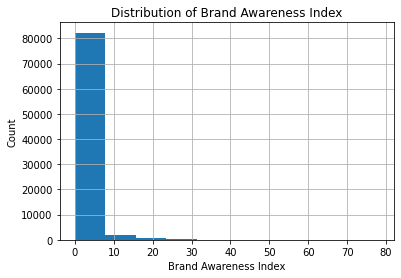

In [12]:
ax = customers.brand_awareness_index.hist()
ax.set_title("Distribution of Brand Awareness Index")
ax.set_xlabel("Brand Awareness Index")
ax.set_ylabel("Count")

In [13]:
customers.head()

,state,age,gender,income,is_married,promo_group_1,promo_group_2,customer_loyalty_index,brand_awareness_index
customer_id,,,,,,,,,
0,NJ,64,Female,65000.0,Y,A,X,0.058849,1.969644e-01
1,NY,26,Female,43000.0,Y,A,Z,-4.872865,2.970386e-14
2,NH,55,Female,93000.0,Y,C,X,NaN,NaN
3,ME,18,Female,68000.0,N,B,Z,0.152339,2.341961e-03
4,CA,41,Female,25000.0,N,A,Y,0.732875,8.073341e-14


          income       age
income  1.000000  0.004502
age     0.004502  1.000000


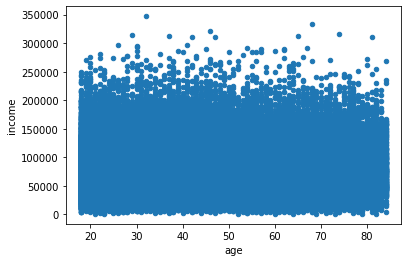

In [14]:
customers.plot.scatter(y = 'income', x = 'age')
print(customers[['income','age']].corr())

In [15]:
customers[['income','age','customer_loyalty_index','brand_awareness_index']].corr()

,income,age,customer_loyalty_index,brand_awareness_index
income,1.000000,0.004502,0.001694,-0.003763
age,0.004502,1.000000,0.002308,-0.000759
customer_loyalty_index,0.001694,0.002308,1.000000,-0.002624
brand_awareness_index,-0.003763,-0.000759,-0.002624,1.000000


#### Initial Takeaways:
- 49% of customers are female, 29% are male, and 20% other
- 56% of customers are not married.
- Customers are only located in Texas, California, New Jersey, New York, and Georgia (evenly distributed)
- 50% of customers are under the age of 42
- 50% of customers have an annual income of $74,000
- No linear relationship between income and age
- No linear relationships between income, age, customer_loyalty, brand_awareness
- Label encode the categorical variables.
- Standard scale continuous variables.
    - Mean imputation for nan values

In [31]:
transactions.head()

,customer_id,transaction_value,transaction_days_after_joining
0,0,5.0,1.0
1,0,2.0,16.0
2,0,10.0,31.0
3,0,8.0,46.0
4,0,9.0,61.0


array([[<AxesSubplot:title={'center':'transaction_value'}>,
        <AxesSubplot:title={'center':'transaction_days_after_joining'}>]],
      dtype=object)

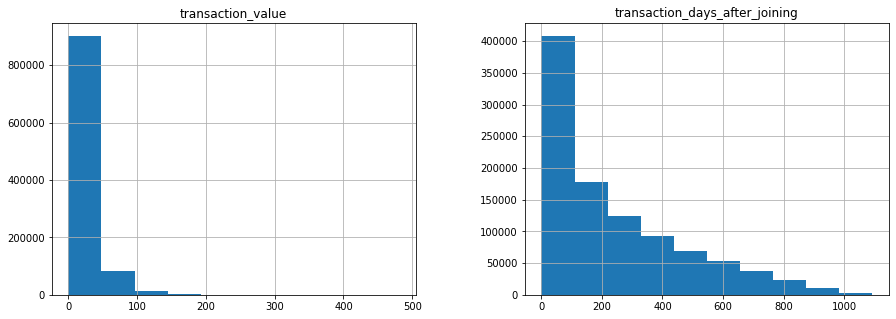

In [32]:
transactions.hist(column = ["transaction_value", "transaction_days_after_joining"],figsize=(15,5))

#### Initial Takeaways:
- Postive skewnewss in transaction values and transaction days after joining
- Transaction values have extreme outliers that we may want to take out

In [ ]:
# 

In [8]:
response = target_variable(transactions)
cont_features = continuous_variables(customers, parameters)
cat_features, label_mapping = categorical_variables(customers, parameters)
feature_table = standardized_feature_table(response, cont_features, cat_features)
X_train, X_test, y_train, y_test = _split_data(feature_table, "6_mo_rolling_transaction_value")

9


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.1s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    2.2s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    2.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.5s finished


Remaining variables:
[['state_label', 'gender_label', 'is_married_label', 'promo_group_1_label', 'promo_group_2_label', 'age', 'income', 'customer_loyalty_index', 'brand_awareness_index']]


The mean squared error (MSE) on test set: 9783.0927
Explained variance: 0.387


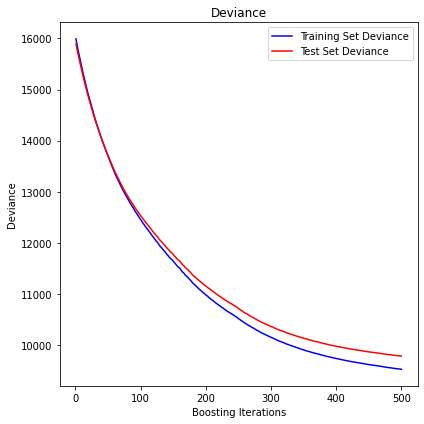

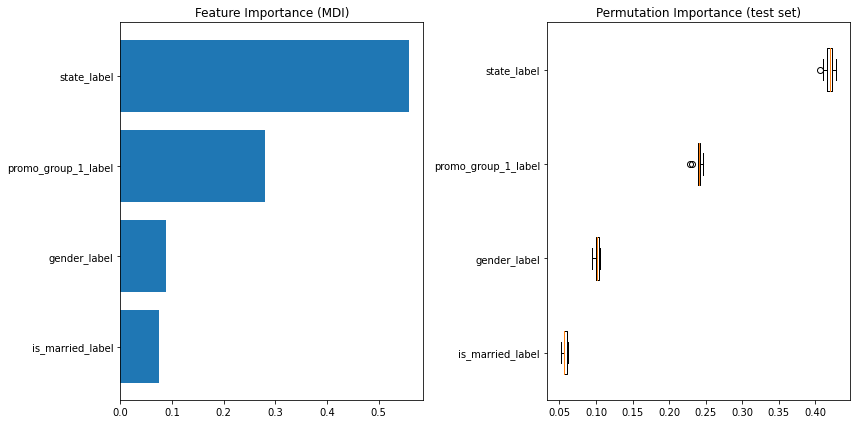

In [9]:
gradBoostReg = gradientBoostingRegressor(X_train, X_test, y_train, y_test)